# Privacy-Preserving Detection of COVID-19 in X-Ray Images (DP-SGD)

###### Notebook settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [ ]:
!pip install tensorflow-privacy

##### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasSGDOptimizer, VectorizedDPKerasAdamOptimizer


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight

import keras
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPool2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, Flatten, ZeroPadding2D
from keras import layers
from tensorflow.keras.applications import ResNet50V2, EfficientNetB0
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

import os, sys, shutil, random, cv2, math
from shutil import copyfile
from distutils.dir_util import copy_tree
from tqdm import tqdm

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [ ]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

##### Define constants

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 8
IMG_SIZE = [256, 256] # dataset image size is 299x299
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 1.0
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

## Data


### Create dataset

In [ ]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [ ]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [ ]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [ ]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [ ]:
# create train-val-test split
x_train, x_val, y_train, y_val = train_test_split(files, labels, test_size=2*SPLIT, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=random_state)

In [ ]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [ ]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set:   ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 3810, 'COVID-19': 2518}
val set:    {'normal': 804, 'COVID-19': 552}
test set:   {'normal': 810, 'COVID-19': 546}


###### Create tensors

In [ ]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [ ]:
def get_img(x, y):
    file_path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [ ]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_ds).numpy()
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 6328, Val: 1356, Test: 1356


### Prepare for training

###### Define preprocessing

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  layers.experimental.preprocessing.Rescaling(scale=1./255)
])

###### Define data augmentation

In [ ]:
# implemented as keras layers below but kept for quick overview
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=(0.85, 1.15), # randomly zoom image 
        brightness_range=(0.9, 1.1), # randomly shift brightness
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='constant',   # constant filling of points outside boundaries of input
        cval=0.,)   # fill with zeros, see fill_mode

In [ ]:
class RandomBrightness(layers.Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='constant'),
  layers.experimental.preprocessing.RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [ ]:
def prepare_training(ds, shuffle=False, repeat=False, augment=False, cache=True, shuffle_buffer_size=1000):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)

    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # repeat training set forever
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)

    # batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # fetches batches in the background while training the model
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_batched = prepare_training(train_ds, shuffle=True, repeat=True, augment=True, cache='cache')
val_batched = prepare_training(val_ds)
test_batched = prepare_training(test_ds)

### Visualization

###### Distribution of labels in the sets

In [ ]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

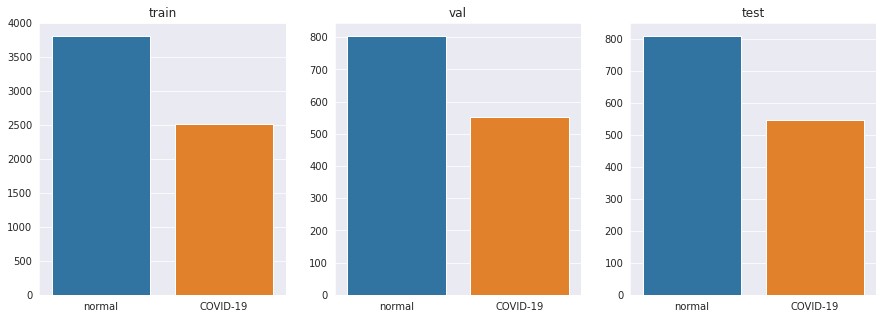

In [ ]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


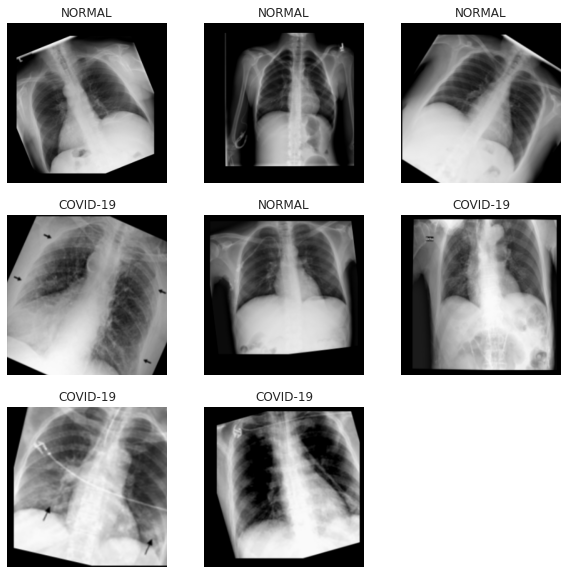

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

Define class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())
print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.26


### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

### Early stopping


In [ ]:
# checkpoint = ModelCheckpoint("x-covid.h5", monitor=monitor='val_loss', save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## DarkNet (DP-SGD)

### Model definition

In [ ]:
def dpnet_builder():
    # create darkenet
    dpnet = Sequential([
        Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        darknet_block(8),
        max_pool(),
        darknet_block(16),
        max_pool(),
        triple_conv(16, 32),
        max_pool(),
        triple_conv(32, 64),
        max_pool(),
        triple_conv(64, 128),
        max_pool(),
        triple_conv(128, 256),
        darknet_block(128, kernel_size=1),
        darknet_block(256),
        darknet_block(3),
        Flatten(),
        Dense(units=1, activation='sigmoid')
    ])
    return dpnet

In [ ]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3 # default: 1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [ ]:
dpnet.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 256, 256, 8)       248       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
sequential_25 (Sequential)   (None, 128, 128, 16)      1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
sequential_29 (Sequential)   (None, 66, 66, 32)        10048     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
sequential_33 (Sequential)   (None, 35, 35, 64)      

### Training

In [ ]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20
791/791 [==============================] - 137s 150ms/step - loss: 0.8684 - accuracy: 0.5683 - precision: 0.3749 - recall: 0.1186 - val_loss: 1.4928 - val_accuracy: 0.5925 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
791/791 [==============================] - 117s 147ms/step - loss: 1.3288 - accuracy: 0.5966 - precision: 0.4777 - recall: 0.0045 - val_loss: 1.1338 - val_accuracy: 0.5932 - val_precision: 1.0000 - val_recall: 0.0018
Epoch 3/20
791/791 [==============================] - 116s 147ms/step - loss: 1.5332 - accuracy: 0.5973 - precision: 0.1130 - recall: 2.3690e-04 - val_loss: 1.4206 - val_accuracy: 0.5925 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
791/791 [==============================] - 116s 147ms/step - loss: 2.1246 - accuracy: 0.5969 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5004 - val_accuracy: 0.5925 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
791/791 [==============================] 

KeyboardInterrupt: ignored

### Evaluation

###### Visualize performance

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].plot(history_dpnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

## Privacy

### Compute epsilon

In [ ]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(math.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [ ]:
# delta rule of thumb: set to less than the inverse of the training data size
delta = 1 / (TRAIN_IMG_COUNT * 1.5)
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS, # early_stopping.stopped_epoch
    delta)
print('Delta = %.e, Epsilon = %.3f'%(delta, eps))

### Attacks